In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from joblib import dump
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [ ]:
# Gerekli nltk verilerini indirme
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [60]:
# Dosya yolları
categories_path = './dataset/Product_Categories.txt'
explanations_path = './dataset/Product_Explanation.txt'

In [61]:
def load_data(file_path, columns):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split(';', 1)
            if len(parts) == 2:
                data.append(parts)

    df = pd.DataFrame(data, columns=columns)
    return df

# Verileri yükle
df_categories = load_data(categories_path, ['id', 'category'])
df_explanations = load_data(explanations_path, ['id', 'description'])

In [62]:
# Veriyi görüntüleme
print(df_categories)
print(df_explanations)

           id                                           category
0         116                           TELEKOM > AKILLI TELEFON
1         462             Bilgisayar > Taşınabilir Bilgisayarlar
2        1286                            Cep Telefonları > APPLE
3        1290                          Cep Telefonları > SAMSUNG
4        1300           Ev Elektroniği > Televizyonlar > SAMSUNG
...       ...                                                ...
1795  1040208  AirTies Air 2411 300mbps 11N Kablosuz USB Adaptör
1796  1040520                   Canon CRG-731C Toner Kartuş Mavi
1797  1040521                Canon CRG-731M Toner Kartuş Kırmızı
1798  1040676  Zyxel NSA-325 2x4TB Disk Destekli Depolama Üni...
1799  1041258  Corsair Force GS 240 GB SSD Disk CSSD-F240GBGS-BK

[1800 rows x 2 columns]
           id                                        description
0         116                                               null
1         462  HP Pavilion 11-n000nt Pentium N3540 4GB 750GB ...


#### İkiside 1800 satır 

In [7]:
# Duplikasyonları kaldırma
df_explanations =  df_explanations.drop_duplicates()
df_categories = df_categories.drop_duplicates()

In [8]:
print(len(df_categories))

1800


In [9]:
print(len(df_explanations))

1800


#### Duplicate yokmuş hala ikiside 1800 satır

In [10]:
# Unique kategori sayısını bul
unique_categories = df_categories['category'].nunique()
print("Toplam farklı kategori sayısı:", unique_categories)

Toplam farklı kategori sayısı: 1165


In [11]:
# Kategori ve id sayımlarını hesaplar
category_counts = df_categories['category'].value_counts()
print(category_counts)

category
                                                              29
Bilgisayar Ürünleri > Tüketim Malzemeleri > Kartuş            12
Telefon > Cep Telefonu                                        11
Toner Kartuş Şerit > Kartuş                                   11
Yazılım > Oyunlar > PC > ARAL                                 10
                                                              ..
BİLGİSAYAR > AĞ/MODEM > MODEM                                  1
OEM Ürünleri > Soğutma Sistemleri > İşlemci > ZALMAN           1
Fotoğraf Makinesi Aksesuarı > Addison                          1
OEM Ürünleri > Soğutma Sistemleri > Sıvı Soğutma > CORSAIR     1
Corsair Force GS 240 GB SSD Disk CSSD-F240GBGS-BK              1
Name: count, Length: 1165, dtype: int64


##### 29 tane (null) kategoriye girmemiş açıklama var

In [12]:
id_counts = df_categories['id'].value_counts()
print(id_counts)

id
116        1
565807     1
543204     1
541486     1
539690     1
          ..
185447     1
185357     1
185348     1
185177     1
1041258    1
Name: count, Length: 1800, dtype: int64


In [13]:
desc_counts = df_explanations['description'].value_counts()
print(desc_counts[:5])

description
null                           190
                               128
Garanti Süresi: 24 Ay 24 Ay     20
Ürün Hakkında                   18
Teknik Özellikler                7
Name: count, dtype: int64


#### null ve boş stringler var

In [14]:
# Kategorileri ve açıklamaları birleştirme
df = pd.merge(df_categories, df_explanations, on='id', how='inner')

#### inner join, her iki veri çerçevesinde de bulunan ortak anahtarları (bu örnekte id sütunu) kullanarak birleştirme yapar. Yani, her iki veri çerçevesinde de mevcut olan id değerlerini içeren satırlar birleştirilir. how='inner' seçeneğini kullanmanın temel nedeni, veri çerçevelerini yalnızca her iki çerçevede de mevcut olan ortak anahtarlar (id) üzerinden birleştirerek veri tutarlılığını ve kalitesini artırmaktır. Bu yüzden inner joini tercih ettim.

In [15]:
# 'null' değerlerini eksik veri olarak işaretler
df.replace('null', pd.NA, inplace=True)
df.replace('', pd.NA, inplace=True)
print(df[df["description"].isnull()])
print(df[df["category"].isnull()])

           id                                           category description
0         116                           TELEKOM > AKILLI TELEFON        <NA>
6        2021                                Cep Telefonu > Sony        <NA>
18       6272                               OEM > Ekran Kartları        <NA>
26       8941                                    MP3 > MP3 ÇALAR        <NA>
30      10082     TV & Görüntü Sistemleri > Ev Sinema Sistemleri        <NA>
...       ...                                                ...         ...
1658   871404         Bilgisayar > Yazıcılar > Kartuş-Toner-Drum        <NA>
1670   942081  Bilgisayar > Bilgisayar Bileşenleri > Tüketim ...        <NA>
1675   948795  Bilgisayar > Çevre Birimleri > Yazıcılar > Mür...        <NA>
1786  1038509     AirTies 5750 ADSL2+/VDSL 1600 Mbps 11 AC Modem        <NA>
1795  1040208  AirTies Air 2411 300mbps 11N Kablosuz USB Adaptör        <NA>

[318 rows x 3 columns]
          id category                               

In [16]:
# Kategorileri gruplandırma ve en çok tekrar edenleri bulma
category_counts = df['category'].value_counts()

In [17]:
# En çok tekrar eden ilk 10 kategoriyi seçme
top_categories = category_counts.head(10)

In [18]:
# Kategorilerin isimlerini al
top_category_names = top_categories.index

/var/folders/lb/9x3f70y57xg2vhmd37q2ysgc0000gn/T/ipykernel_5591/1152349498.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_category_names, y=top_categories.values, palette='viridis', legend=False)


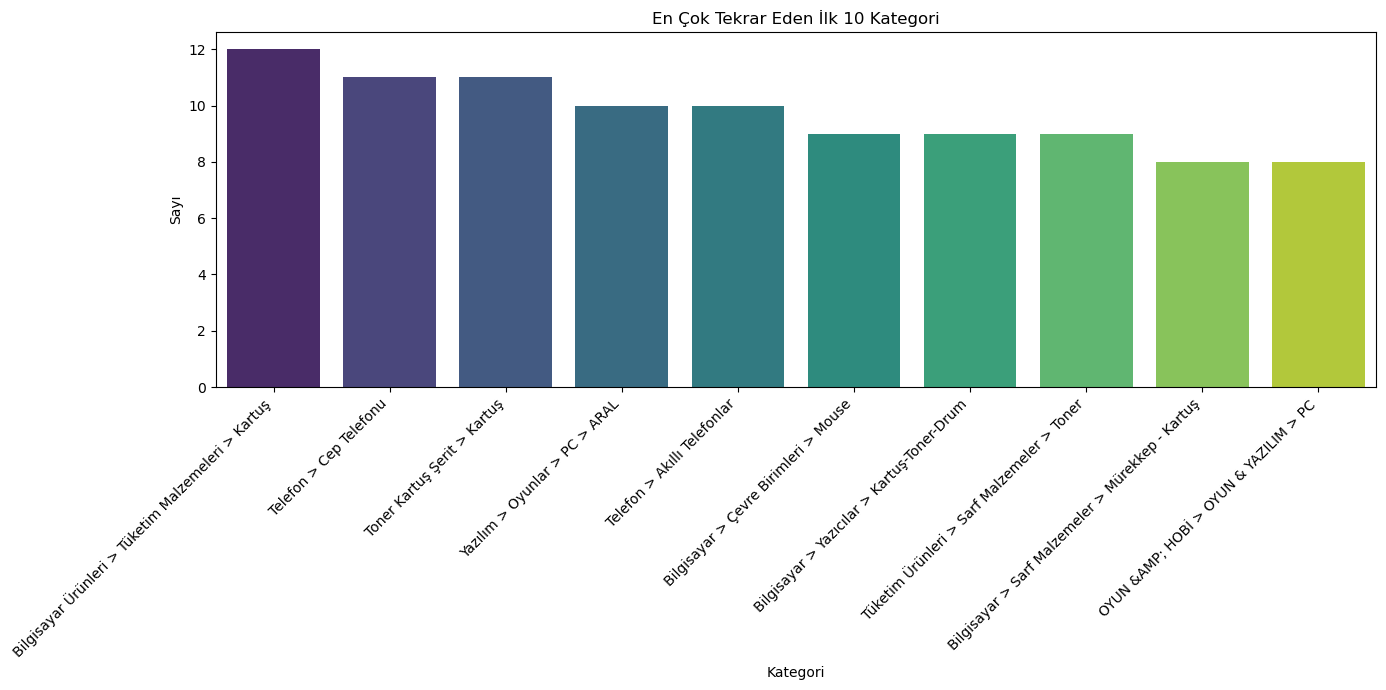

In [19]:
# Görselleştirme
plt.figure(figsize=(14, 7))
sns.barplot(x=top_category_names, y=top_categories.values, palette='viridis', legend=False)
plt.xlabel('Kategori')
plt.ylabel('Sayı')
plt.title('En Çok Tekrar Eden İlk 10 Kategori')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

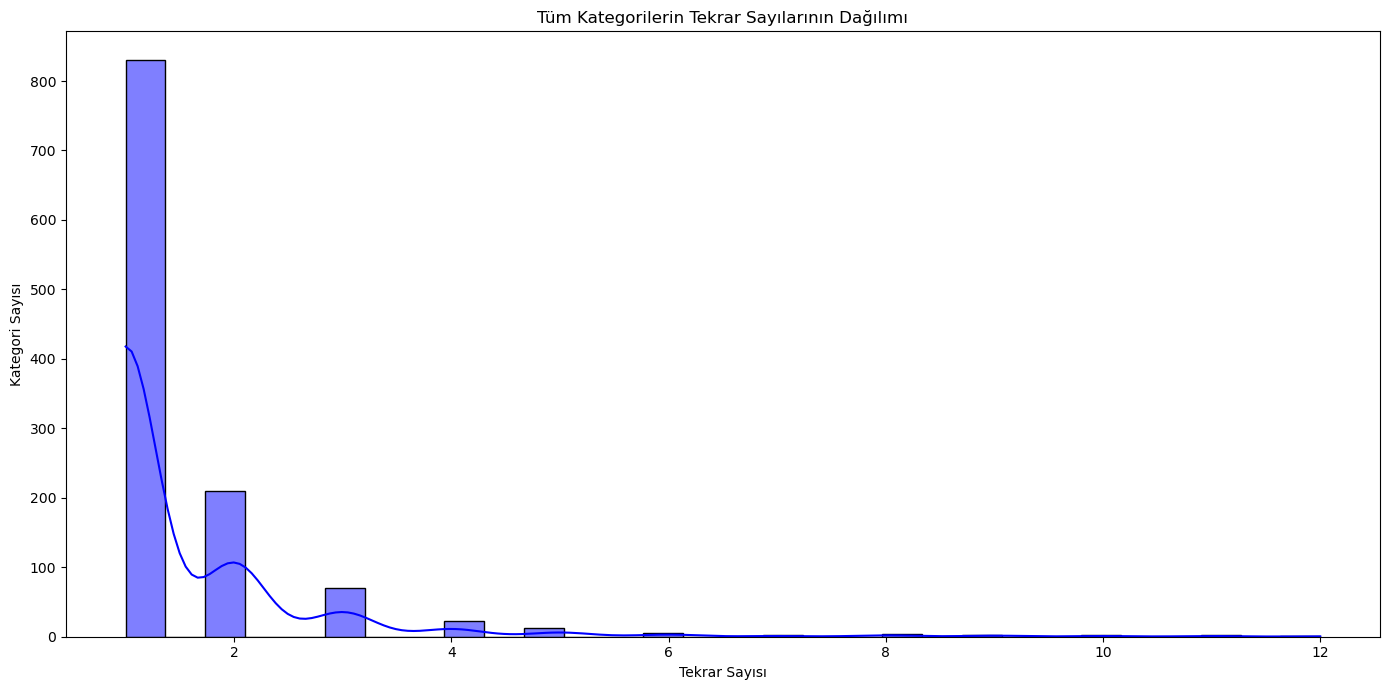

In [20]:
# Tüm kategorilerin tekrar sayıları için bir dağılım grafiği oluşturma
plt.figure(figsize=(14, 7))
sns.histplot(category_counts.values, kde=True, bins=30, color='blue')
plt.xlabel('Tekrar Sayısı')
plt.ylabel('Kategori Sayısı')
plt.title('Tüm Kategorilerin Tekrar Sayılarının Dağılımı')
plt.tight_layout()
plt.show()

In [21]:
# Bir kere geçen kategori sayısını bulma
single_occurrence_categories = category_counts[category_counts == 1].count()
print(f"Bir kere geçen kategori sayısı: {single_occurrence_categories}")

Bir kere geçen kategori sayısı: 830


In [23]:
# Eksik verilerin kontrolü
print(df.isnull().sum())

id               0
category        29
description    318
dtype: int64


In [24]:
# Eksik verinin dataya oranını hesaplar
missing_data_percentage = df.isnull().mean() * 100
print(missing_data_percentage)

id              0.000000
category        1.611111
description    17.666667
dtype: float64


In [25]:
# Category sütunundaki eksik verileri Other ile doldurur
df.loc[df['category'].isnull(), 'category'] = 'Other'

#### Description eksik olan kategorilerin açıklamalarını, aynı kategoriye ait açıklamaların bulunduğu satırlardan rastgele seçerek doldurmayı amaçlamaktadır.


In [26]:
missing_desc_df = df[df['description'].isnull()]
missing_cat_list = missing_desc_df['category']
missing_desc_cat_map_df = df[(df['category'].isin(missing_cat_list)) & (~df['description'].isnull())]
missing_desc_cat_map_df

for index, row in missing_desc_df.iterrows():
    descs = missing_desc_cat_map_df[missing_desc_cat_map_df['category'] == row['category']]['description']
    if len(descs) == 0:
        continue
    desc = descs.sample(1).values[0]
    df.loc[index, 'description'] = desc

In [27]:
# Veriyi inceleme
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1800 non-null   object
 1   category     1800 non-null   object
 2   description  1546 non-null   object
dtypes: object(3)
memory usage: 42.3+ KB
None


#### Eksik verileri droplar

In [28]:
df = df.dropna()

### Aşğıdaki kısımda description kısmındaki texti ikiye bölüp ekstra satır olarak ekleyip datamı genişletmeye çalıştım ama daha iyi bir sonuç alamadım.

In [29]:
#def sssplit(text):
 #   l = len(text) // 2
 #   return [text[:l], text[l:]]

In [30]:
#df['description'] = df['description'].apply(sssplit)

In [31]:
#df = df.explode('description')

In [32]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1546 entries, 1 to 1799
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1546 non-null   object
 1   category     1546 non-null   object
 2   description  1546 non-null   object
dtypes: object(3)
memory usage: 48.3+ KB
None


In [33]:
# Lemmatizer oluşturma
lemmatizer = WordNetLemmatizer()

In [35]:
# Metin önişleme fonksiyonu
def preprocess_text(text):
    text = text.lower()  # Küçük harfe çevirir
    tokens = word_tokenize(text)  # Tokenize eder
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha()]  # Lemmatize eder ve sadece alfabetik kelimeleri tutar.
    stop_words = set(stopwords.words('turkish'))  # Türkçe stop words
    tokens = [word for word in tokens if word not in stop_words]  # Stop words'leri çıkarır.
    return ' '.join(tokens)

In [36]:
# Açıklama sütununu önişler
df['description'] = df['description'].apply(preprocess_text)

In [37]:
# Veriyi eğitim ve test olarak böler verinin %10 unu test %90 ını train olarak ayırdım.
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['category'], test_size=0.1, random_state=42)

gram_range=(1, 2), max_features=80 açıkla

In [38]:
# TF-IDF Vektörleştirme
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=800)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [39]:
# TF-IDF vektörlerinin boyutunu kontrol eder.
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(1391, 800)
(155, 800)


In [40]:
# Lojistik Regresyon Modeli ve Hiperparametreler
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy')

#### C ve solver, modelin en temel iki yönünü doğrudan kontrol eder: regularizasyon ve optimizasyon. Bu iki parametre, modelin karmaşıklığını ve performansını büyük ölçüde etkiler. Bu yüzden bu paremetreleri seçtim.

In [41]:
# Grid Search ile en iyi parametreleri bulma
grid_search.fit(X_train_tfidf, y_train)
best_log_reg_params = grid_search.best_params_
print(f"En iyi parametreler: {best_log_reg_params}")
print(f"En iyi doğruluk: {grid_search.best_score_}")

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


En iyi parametreler: {'C': 10, 'solver': 'liblinear'}
En iyi doğruluk: 0.20129372408827984


In [42]:
# En iyi parametreleri kullanarak lojistik regresyon modelini eğitme
best_log_reg_model = LogisticRegression(max_iter=1000, class_weight='balanced', **best_log_reg_params)
best_log_reg_model.fit(X_train_tfidf, y_train)
y_pred = best_log_reg_model.predict(X_test_tfidf)

In [43]:
# Performans Metrikleri
print(f"Test seti doğruluğu: {accuracy_score(y_test, y_pred)}")
print(f"Test seti F1 skoru: {f1_score(y_test, y_pred, average='weighted')}")

Test seti doğruluğu: 0.1935483870967742
Test seti F1 skoru: 0.19032258064516128


#### Accuracy (Doğruluk), modelin tüm örnekler arasında ne kadar doğru tahmin yaptığını gösterir.
#### F1 SKORU, precision (kesinlik) ve recall (duyarlılık) metriklerinin harmonik ortalamasıdır. 
#### Tek bir metrik, tüm performans ölçütlerini yansıtamayabilir. Accuracy yüksek olabilir, ancak bu, modelin belirli sınıflar üzerinde iyi performans gösterdiği anlamına gelmeyebilir. F1 skoru, precision ve recall arasındaki dengeyi sağlayarak daha adil bir değerlendirme sunar.

In [44]:
print("Lojistik Regresyon Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

Lojistik Regresyon Sınıflandırma Raporu:
                                                                                                                                       precision    recall  f1-score   support

                                                                                         Aile Sağlığı ve Bakımı > Ağız ve Diş Sağlığı       0.00      0.00      0.00         0
                                                                      Aksesuar & Sarf Malz. > Projeksiyon Aksesuarları > Askı Aparatı       1.00      1.00      1.00         1
                                                                                  Aksesuar & Sarf Malz. > Çantalar > Tablet Çantaları       0.00      0.00      0.00         1
                                                                                                  Aksesuar & Sarf Malz. > Çeviriciler       0.00      0.00      0.00         1
                                             Aksesuar > Çanta - Kılıf > Tablet Kılı

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.1

In [32]:
print("Lojistik Regresyon Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))


Lojistik Regresyon Sınıflandırma Raporu:
                                                                                                                                             precision    recall  f1-score   support

                                                                                                         ANAKART > GIGABYTE > Z97X-Gaming 5       0.00      0.00      0.00         0
                                                                                           Aksesuar & Sarf Malz. > Kablolar > Ses Kabloları       0.00      0.00      0.00         1
                                                                            Aksesuar & Sarf Malz. > Projeksiyon Aksesuarları > Askı Aparatı       0.00      0.00      0.00         1
                                                                                                           Aksesuar > Notebook Aksesuarları       0.00      0.00      0.00         1
                                                     

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.1

In [45]:
# Modeli ve vectorizer'ı kaydetme
dump(best_log_reg_model, './models/logistic_regression_model.joblib')
dump(vectorizer, './models/tfidf_vectorizer.joblib')

['./models/tfidf_vectorizer.joblib']

#### Lojistik Regresyon ile oluşturduğum modelin doğruluk skoru yaklaşık olarak 0.2, F1 skoru ise 0.19 başka bir model deniyerek daha iyi bir sonuç alabilir miyim diye yeni bir model oluşturucam.

In [46]:
# Random Forest için hiperparametreler
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

####  n_estimators: Ormandaki ağaç sayısını belirler
####  max_depth: Her ağacın maksimum derinliğini belirler 
####  min_samples_split: Bir düğümün bölünmesi için gereken minimum örnek sayısını belirler 
####  min_samples_leaf: Bir yaprak düğümde bulunması gereken minimum örnek sayısını belirler 
####  bootstrap: Bootstrap örneklemeyi kullanıp kullanmayacağını belirler (örneğin, True, False).

In [47]:
# Grid Search ile en iyi parametrelerin bulunması
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_tfidf, y_train)
best_rf_params = rf_grid_search.best_params_
print(f"En iyi Random Forest parametreleri: {best_rf_params}")
print(f"En iyi Random Forest doğruluk: {rf_grid_search.best_score_}")

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


En iyi Random Forest parametreleri: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
En iyi Random Forest doğruluk: 0.2415639507460093


In [48]:
# En iyi parametreleri kullanarak random forest modelini eğitme
best_rf_model = RandomForestClassifier(random_state=42, **best_rf_params)
best_rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = best_rf_model.predict(X_test_tfidf)

In [40]:
# Random Forest Modeli
#rf_model = RandomForestClassifier(random_state=42)

In [49]:
# Performans Metrikleri
print(f"Random Forest Test seti doğruluğu: {accuracy_score(y_test, y_pred_rf)}")
print(f"Random Forest Test seti F1 skoru: {f1_score(y_test, y_pred_rf, average='weighted')}")

Random Forest Test seti doğruluğu: 0.2645161290322581
Random Forest Test seti F1 skoru: 0.2602150537634409


In [50]:
print("Random Forest Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred_rf))

Random Forest Sınıflandırma Raporu:
                                                                                                                                       precision    recall  f1-score   support

                                                                      Aksesuar & Sarf Malz. > Projeksiyon Aksesuarları > Askı Aparatı       1.00      1.00      1.00         1
                                                                                  Aksesuar & Sarf Malz. > Çantalar > Tablet Çantaları       0.00      0.00      0.00         1
                                                                                                  Aksesuar & Sarf Malz. > Çeviriciler       0.00      0.00      0.00         1
                                             Aksesuar > Çanta - Kılıf > Tablet Kılıfı > Addison IP-262 7" Tablet Kılıfı Standlı Pembe       0.00      0.00      0.00         1
                                                                    Aksesuar Ürünleri > 

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/ml/lib/python3.1

In [51]:
# Modeli ve vectorizer'ı kaydetme
dump(best_rf_model, './models/random_forest_model.joblib')
dump(vectorizer, './models/tfidf_vectorizer.joblib')

['./models/tfidf_vectorizer.joblib']

#### Random forest modelinde ise doğruluğu: 0.264, F1 skoru: 0.260 
#### Random Forest, Logistic Regression'a göre daha yüksek bir doğruluk oranına sahip. Bu, modelin test veri setindeki doğru sınıflandırmalarının daha fazla olduğunu gösterir. Random Forest'ın daha yüksek bir F1 skoruna sahip olması, hem doğru pozitifleri daha iyi yakaladığını hem de yanlış pozitiflerin sayısını daha düşük tuttuğunu gösterir. Bu yüzden Random Forest modelini kullanıcam.